In [1]:
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

### Data loading and visualisation

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

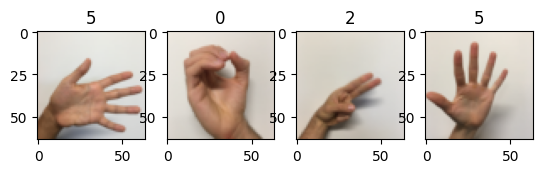

In [3]:
def load_train_test():
    train_dataset = h5py.File('train_signs.h5')
    test_dataset = h5py.File('test_signs.h5')
    X_train = np.array(train_dataset['train_set_x'])
    Y_train = np.array(train_dataset['train_set_y'])
    
    X_test = np.array(test_dataset['test_set_x'])
    Y_test = np.array(test_dataset['test_set_y'])
    return X_train, X_test, Y_train, Y_test
    
X_train, X_test, Y_train, Y_test = load_train_test()
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(X_train[i])
    ax[i].set_title(Y_train[i])

### Reshaping data and converting to torch tensor to speed up net training

In [4]:
X_train = torch.from_numpy(X_train.reshape(-1, 3, 64, 64)) / 255
X_test = torch.from_numpy(X_test.reshape(-1, 3, 64, 64)) / 255
Y_train = torch.from_numpy(Y_train).to(torch.int64)
Y_test = torch.from_numpy(Y_test).to(torch.int64)

X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

In [5]:
X_train.shape, X_test.shape

(torch.Size([1080, 3, 64, 64]), torch.Size([120, 3, 64, 64]))

### Model with convolution layers

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.linear1 = nn.Linear(12544, 4000)
        self.linear2 = nn.Linear(4000, 800)
        self.linear3 = nn.Linear(800, 500)
        self.linear4 = nn.Linear(500, 6)

        self.softmax = nn.Softmax(dim=1)

        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)

        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.kaiming_normal_(self.linear2.weight)
        nn.init.kaiming_normal_(self.linear3.weight)
        nn.init.kaiming_normal_(self.linear4.weight)

    def forward(self, x):
        B = x.shape[0]

        x = self.relu(self.maxpool1(self.conv1(x)))
        
        x = self.relu(self.maxpool2(self.conv2(x)))

        x = x.view(B, -1)

        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.tanh(self.linear3(x))
        x = self.tanh(self.linear4(x))

        return self.softmax(x)

model = CNN().to(device)

### Hyperparameters

In [7]:
lr = 0.000001
batch_size = 50
epochs = 3000
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
criterion = nn.CrossEntropyLoss()
lossi = []

### Training model

In [8]:
model.train()

batch = torch.randint(0, X_train.shape[0], size=(batch_size, )).to(device)

for epoch in range(epochs):
    inp = X_train[batch]
    prediction = model(inp)
    loss = criterion(prediction, Y_train[batch])
    optimizer.zero_grad(set_to_none=True)  
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
    if epoch % 100 == 0:
        print(f"{epoch=}, {loss.item()=}")

loss.item()

epoch=0, loss.item()=1.7892236709594727
epoch=100, loss.item()=1.640536904335022
epoch=200, loss.item()=1.5550813674926758
epoch=300, loss.item()=1.4936729669570923
epoch=400, loss.item()=1.4813348054885864
epoch=500, loss.item()=1.4324508905410767
epoch=600, loss.item()=1.4279757738113403
epoch=700, loss.item()=1.3984062671661377
epoch=800, loss.item()=1.3936810493469238
epoch=900, loss.item()=1.3928630352020264
epoch=1000, loss.item()=1.3924130201339722
epoch=1100, loss.item()=1.3921141624450684
epoch=1200, loss.item()=1.391899824142456
epoch=1300, loss.item()=1.3917385339736938
epoch=1400, loss.item()=1.391611933708191
epoch=1500, loss.item()=1.3915101289749146
epoch=1600, loss.item()=1.3914260864257812
epoch=1700, loss.item()=1.3913542032241821
epoch=1800, loss.item()=1.3912919759750366
epoch=1900, loss.item()=1.391238808631897
epoch=2000, loss.item()=1.39119291305542


KeyboardInterrupt: 

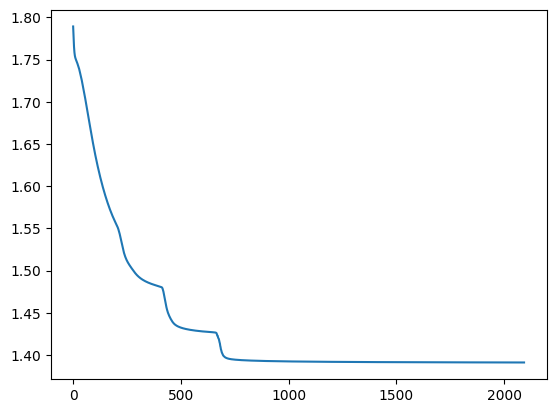

In [9]:
plt.plot(lossi)

## Model estimation

In [13]:
model.eval()
total = X_test.shape[0]
correct = 0

classes_with_most_error = {
    "0": 0,
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0
}
loss_test = []
for inp in range(X_test.shape[0]):
    prediction = model(X_test[inp].unsqueeze(0))
    loss = criterion(prediction, Y_test[inp].unsqueeze(0))
    loss_test.append(loss.item())
    
    if prediction.argmax(dim=1) == Y_test[inp]:
        correct += 1
    else:
        classes_with_most_error[str(prediction.argmax(dim=1).item())] += 1
    total += 1

print("Mean loss = ", torch.mean(torch.tensor(loss_test)))
# print(classes_with_most_error)
print("Accuracy = ", correct / total * 100, "%")

Mean loss =  tensor(1.6917)
Accuracy =  40 %
